# Automation, Scrapping and Exploratory Analysis Project on BBC GoodFood Website

## About BBC GoodFood

BBC Good Food is a global food media brand, with a monthly magazine, website, app, live events and series of books. BBC Good Food magazine was awarded Food and Drink Magazine of the year at the DMA 2013 Digital Magazine Awards and Digital Magazine Of The Year at the PPA Digital Publishing Awards 2013.

## About the Project:

In this project, we have attempted to scrape the details of food recipies from the **BBC GoodFood** website and have performed Exploratory analysis on the scraped data in the effort of getting deeper insight into recipies, their attributes such as nutritional values, preparation time, etc. and their demands based on various factors

### Automating the web driver

Importing the **Selenium** library and other relevant libraries and modules for the automation purpose

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import pyautogui
import time
import re
import numpy as np
import pandas as pd

Initiating the webdriver and opening the intended webpage

In [2]:
ops=webdriver.ChromeOptions()
ops.add_argument("--disable-notifications")

In [3]:
srv=Service("C:\py_selenium\chromedriver_win32\chromedriver.exe")
driver=webdriver.Chrome(service=srv,options=ops)

Incompatible release of chromedriver (version 113.0.5672.63) detected in PATH: C:\webdrivers\chromedriver.exe


In [4]:
driver.get("https://www.bbcgoodfood.com/")
driver.maximize_window()

In [5]:
# import time
# time.sleep(5)
# driver.find_element(By.XPATH,"//button[text()='AGREE']").click()

Performing a click using the **PyAutoGUI** library on a dynamically loading Pop-up window, since it was not recognizable in the website script to use selenium.

In [7]:
# alert=driver.switch_to.alert
# print(alert.text)
screen_width, screen_height = pyautogui.size()
x = int(screen_width * 0.6)  # Adjust as needed
y = int(screen_height * 0.75)  # Adjust as needed

pyautogui.moveTo(x, y)
pyautogui.click()
time.sleep(2)

### Scrapping the details

Importing the **BeautifulSoup** library and scrapping the relevant details for our case-study.

In [8]:
from bs4 import BeautifulSoup
import requests

In [9]:
def func_time(ul_element):
    first_li = ul_element.find_all('li')[0]

    prep_time_ul = first_li.find('ul', class_='list')

    prep_ele = prep_time_ul.find('li')
    # prep_text = prep_ele.get_text(separator=' ', strip=True) if prep_ele else None
    prep_text = prep_ele.find('time').get_text(strip=True) if prep_ele else None
    # print(prep_text)

    cook_ele = prep_ele.find_next_sibling('li')
    # cook_text = cook_ele.get_text(separator=' ', strip=True) if cook_ele else None
    cook_time = cook_ele.find('time') if cook_ele else None
    cook_text = cook_time.get_text(strip=True) if cook_time else None
    # print(cook_text)
    return [('Prep', prep_text), ('Cook', cook_text)]



def func_difficulty(ul_element):
    if ul_element.find('div', class_='post-header__skill-level'):
        return ul_element.find('div', class_='post-header__skill-level').get_text(strip=True)
    else:
        return None

    
def func_serves(ul_element):
    if ul_element.find('div', class_='post-header__servings'):
        return ul_element.find('div', class_='post-header__servings').get_text(strip=True)
    else:
        return None

def func_nutritional_vals(doc):
    nutrition_table = doc.find('table', class_="key-value-blocks")
    #print(nutrition_table.caption.string)

    tbodies = nutrition_table.find_all('tbody')
    nutrition_values = []

    for tbody in tbodies:
        for row in tbody.find_all('tr'):
            tdata = row.find_all('td')
            if len(tdata) > 2:
                nutrition_values.append((tdata[1].get_text(strip=True), tdata[-1].get_text(strip=True)))
            elif len(tdata) == 2:
                nutrition_values.append((tdata[0].get_text(strip=True), tdata[-1].get_text(strip=True)))
    #print(nutrition_values)
    return nutrition_values
                

def func_rating(doc):
    if not doc.find('div', class_='rating__values'):
        return None

    rating_string = doc.find('div', class_='rating__values').select('span.sr-only')[0].get_text(strip=True)
    rating_match = re.findall(r'\d+(?:\.\d+)?', rating_string)
    rating = float(rating_match[0]) if rating_match else None
    # print(rating)

    rating_count = doc.select('span.rating__count-text')[0].get_text(strip=True)
    # print(rating_count)
    return rating,rating_count

In [10]:
def func_scrape_dets(url):
    response = requests.get(url)
    doc = BeautifulSoup(response.content, "html.parser")
    title = doc.find(class_="heading-1")
    print(title.text)
    
    #func_scrape_dets(parent[0])
    
    ul_element = doc.find('ul', class_="post-header__planning")
    #ul_children = ul_element.children
    
    #li_elements = [child for child in ul_children if child.name == 'li']
    
    #getting prep and cook time
    time = func_time(ul_element)
    
    #getting difficulty
    difficulty = func_difficulty(ul_element)
    
    #getting serves
    serves = func_serves(ul_element)
    
    #getting nutritional values
    nutritions = func_nutritional_vals(doc)
    
    #getting ratings for popularity        
    rating = func_rating(doc)
    
    print(time)
    print(difficulty)
    print(serves)
    print(nutritions)
    print(rating)

In [11]:
# func_scrape_dets(parent[0])

Checking if the functions work properly as intended, for one element

In [12]:
func_scrape_dets("https://www.bbcgoodfood.com/recipes/chicken-chorizo-jambalaya")

Chicken & chorizo jambalaya
[('Prep', '10 mins'), ('Cook', '45 mins')]
Easy
Serves 4
[('kcal', '445'), ('fat', '10g'), ('saturates', '3g'), ('carbs', '64g'), ('sugars', '7g'), ('fibre', '2g'), ('protein', '30g'), ('salt', '1.2g')]
(4.8, '2545 ratings')


Taking a particular set of ingredients, whose recipies of dishes we want to scrape and perform analysis on.

In [13]:
ingredients=["chicken", "mushroom", "fish", "egg", "paneer", "beef", "soy bean"]

In [16]:
#getting the url of all the dishes

parent=[]
item_freq = []
def func_getItems(driver):
    item=driver.find_elements(By.CLASS_NAME,"heading-4")
    item=item[1:len(item)-1]
    count = 0;
    for i in range(len(item)):
        parent.append(item[i].find_element(By.XPATH,"./parent::a").get_attribute('href'))
        count = count + 1
    item_freq.append(count)

Automated the search of dishes and storing their urls for later scrapping

In [17]:
for ingredient in ingredients:
    searchbox=driver.find_element(By.CLASS_NAME,"form-input")
    searchbox.clear()
    searchbox.send_keys(ingredient)
    searchbox.submit()
    func_getItems(driver)
    driver.back()

In [18]:
#since each page by default loads 30 elements and we have taken 7 ingredients into consideration, hence 210 elements

len(parent)

210

In [19]:
#their parent a tag which has the href
# parent=[]
# for i in range(len(item)):
#     parent.append(item[i].find_element(By.XPATH,"./parent::a").get_attribute('href'))

In [20]:
item_freq

[30, 30, 30, 30, 30, 30, 30]

In [21]:
parent

['https://www.bbcgoodfood.com/recipes/chicken-chorizo-jambalaya',
 'https://www.bbcgoodfood.com/recipes/chicken-noodle-soup',
 'https://www.bbcgoodfood.com/recipes/chicken-pasta-bake',
 'https://www.bbcgoodfood.com/recipes/chicken-jalfrezi',
 'https://www.bbcgoodfood.com/recipes/chinese-chicken-curry',
 'https://www.bbcgoodfood.com/recipes/chicken-satay-salad',
 'https://www.bbcgoodfood.com/recipes/chicken-arrabbiata-stew-parmesan-dumplings',
 'https://www.bbcgoodfood.com/recipes/chicken-white-bean-stew',
 'https://www.bbcgoodfood.com/recipes/chicken-chorizo-ragu',
 'https://www.bbcgoodfood.com/recipes/summer-winter-chicken',
 'https://www.bbcgoodfood.com/recipes/mustard-stuffed-chicken',
 'https://www.bbcgoodfood.com/recipes/chicken-biryani',
 'https://www.bbcgoodfood.com/recipes/easy-chicken-curry',
 'https://www.bbcgoodfood.com/recipes/healthier-chicken-balti',
 'https://www.bbcgoodfood.com/recipes/chicken-and-bean-enchiladas',
 'https://www.bbcgoodfood.com/recipes/home-style-chicke

Applying the actual scrapping for all the extracted urls

In [22]:
for i in parent:
    func_scrape_dets(i)

Chicken & chorizo jambalaya
[('Prep', '10 mins'), ('Cook', '45 mins')]
Easy
Serves 4
[('kcal', '445'), ('fat', '10g'), ('saturates', '3g'), ('carbs', '64g'), ('sugars', '7g'), ('fibre', '2g'), ('protein', '30g'), ('salt', '1.2g')]
(4.8, '2545 ratings')
Chicken noodle soup
[('Prep', '10 mins'), ('Cook', '30 mins')]
Easy
Serves 2
[('kcal', '217'), ('fat', '2g'), ('saturates', '0.4g'), ('carbs', '26g'), ('sugars', '1g'), ('fibre', '0.6g'), ('protein', '26g'), ('salt', '2.5g')]
(4.8, '751 ratings')
Chicken pasta bake
[('Prep', '30 mins'), ('Cook', '45 mins')]
Easy
Serves 6
[('kcal', '575'), ('fat', '30g'), ('saturates', '14g'), ('carbs', '41g'), ('sugars', '9g'), ('fibre', '5g'), ('protein', '33g'), ('salt', '0.5g')]
(4.7, '593 ratings')
Chicken jalfrezi
[('Prep', '10 mins'), ('Cook', '1 hr')]
Easy
Serves 4
[('kcal', '252'), ('fat', '8g'), ('saturates', '1g'), ('carbs', '11g'), ('sugars', '9g'), ('fibre', '5g'), ('protein', '30g'), ('salt', '0.4g')]
(4.5, '459 ratings')
Chinese chicken cur

Chicken and mushrooms
[('Prep', '15 mins'), ('Cook', '25 mins')]
Easy
Serves 4
[('kcal', '260'), ('fat', '13g'), ('saturates', '3g'), ('carbs', '3g'), ('sugars', '1g'), ('fibre', '3g'), ('protein', '32g'), ('salt', '0.9g')]
(4.5, '295 ratings')
Creamy mushroom pasta
[('Prep', '15 mins'), ('Cook', '25 mins')]
Easy
Serves 4
[('kcal', '801'), ('fat', '52g'), ('saturates', '30g'), ('carbs', '45g'), ('sugars', '4g'), ('fibre', '5g'), ('protein', '29g'), ('salt', '0.97g')]
(4.3, '128 ratings')
Mushroom & spinach risotto
[('Prep', '50 mins'), ('Cook', None)]
More effort
Serves 2
[('kcal', '574'), ('fat', '22g'), ('saturates', '10g'), ('carbs', '70g'), ('sugars', '0g'), ('fibre', '5g'), ('protein', '17g'), ('salt', '1.93g')]
(4.8, '279 ratings')
Chicken & mushroom puff pie
[('Prep', '45 mins'), ('Cook', '30 mins')]
Easy
Serves 4 - 6
[('kcal', '855'), ('fat', '47g'), ('saturates', '17g'), ('carbs', '57g'), ('sugars', '6g'), ('fibre', '1g'), ('protein', '55g'), ('salt', '2.7g')]
(4.8, '431 ratin

Greek-style roast fish
[('Prep', '10 mins'), ('Cook', '50 mins')]
Easy
Serves 2
[('kcal', '388'), ('fat', '13g'), ('saturates', '2g'), ('carbs', '42g'), ('sugars', '11g'), ('fibre', '6g'), ('protein', '23g'), ('salt', '0.4g')]
(4.3, '151 ratings')
Creamy fish & leek pie
[('Prep', '20 mins'), ('Cook', '1 hr and 45 mins')]
Easy
Serves 4-6
[('kcal', '833'), ('fat', '60g'), ('saturates', '35g'), ('carbs', '42g'), ('sugars', '6g'), ('fibre', '6g'), ('protein', '24g'), ('salt', '1.2g')]
(4.7, '61 ratings')
Ultimate fish cakes
[('Prep', '25 mins'), ('Cook', '30 mins')]
More effort
Serves 4
[('kcal', '359'), ('fat', '12g'), ('saturates', '2g'), ('carbs', '36g'), ('sugars', '3g'), ('fibre', '2g'), ('protein', '29g'), ('salt', '0.7g')]
(4.7, '165 ratings')
Thai-style steamed fish
[('Prep', '10 mins'), ('Cook', '15 mins')]
Easy
Serves 2
[('kcal', '199'), ('fat', '7g'), ('saturates', '2g'), ('carbs', '4g'), ('sugars', '0g'), ('fibre', '0g'), ('protein', '29g'), ('salt', '3.25g')]
(4.5, '222 rating

Poached eggs with smashed avocado & tomatoes
[('Prep', '10 mins'), ('Cook', '10 mins')]
Easy
Serves 2
[('kcal', '385'), ('fat', '20g'), ('saturates', '4g'), ('carbs', '31g'), ('sugars', '5g'), ('fibre', '8g'), ('protein', '16g'), ('salt', '0.5g')]
(4.5, '28 ratings')
Egg custard
[('Prep', '10 mins'), ('Cook', '40 mins')]
Easy
Serves 4
[('kcal', '434'), ('fat', '36g'), ('saturates', '21g'), ('carbs', '18g'), ('sugars', '18g'), ('fibre', '0g'), ('protein', '9g'), ('salt', '0.3g')]
(4.8, '16 ratings')
Easy egg-fried rice
[('Prep', '10 mins'), ('Cook', '10 mins')]
Easy
Serves 4
[('kcal', '387'), ('fat', '14g'), ('saturates', '2g'), ('carbs', '53g'), ('sugars', '2g'), ('fibre', '1g'), ('protein', '12g'), ('salt', '0.2g')]
(3.8, '86 ratings')
Sweet potato cakes with poached eggs
[('Prep', '15 mins'), ('Cook', '15 mins')]
More effort
Serves 4
[('kcal', '507'), ('fat', '15g'), ('saturates', '4g'), ('carbs', '72g'), ('sugars', '23g'), ('fibre', '7g'), ('protein', '18g'), ('salt', '0.9g')]
(4.3,

Paneer chutney pakora
[('Prep', '25 mins'), ('Cook', '15 mins')]
Easy
Serves 4 as a starter
[('kcal', '531'), ('fat', '36g'), ('saturates', '17g'), ('carbs', '17g'), ('sugars', '2g'), ('fibre', '3g'), ('protein', '33g'), ('salt', '2g')]
(5.0, '1 rating')
Spiced paneer
[('Prep', '50 mins'), ('Cook', None)]
Easy
Serves 4 as a main, or 6-8 as a side dish
[('kcal', '463'), ('fat', '34g'), ('saturates', '16g'), ('carbs', '16g'), ('sugars', '3g'), ('fibre', '2g'), ('protein', '24g'), ('salt', '3.75g')]
(4.0, '30 ratings')
Paneer & chickpea pulao
[('Prep', '15 mins'), ('Cook', '40 mins')]
Easy
Serves 6
[('kcal', '414'), ('fat', '16g'), ('saturates', '7g'), ('carbs', '48g'), ('sugars', '4g'), ('fibre', '5g'), ('protein', '18g'), ('salt', '1.3g')]
(4.0, '5 ratings')
Sticky paneer mango naans with herby yogurt
[('Prep', '20 mins'), ('Cook', '5 mins')]
Easy
Serves 1
[('kcal', '1023'), ('fat', '44g'), ('saturates', '21g'), ('carbs', '101g'), ('sugars', '28g'), ('fibre', '11g'), ('protein', '50g'),

Beef tacos
[('Prep', '10 mins'), ('Cook', '30 mins')]
More effort
Serves 3
[('kcal', '792'), ('fat', '44g'), ('saturates', '16g'), ('carbs', '51g'), ('sugars', '8g'), ('fibre', '9g'), ('protein', '44g'), ('salt', '1.7g')]
(4.6, '29 ratings')
Next level beef stroganoff
[('Prep', '10 mins'), ('Cook', '25 mins')]
Easy
Serves 4
[('kcal', '438'), ('fat', '34g'), ('saturates', '20g'), ('carbs', '3g'), ('sugars', '3g'), ('fibre', '2g'), ('protein', '30g'), ('salt', '2.1g')]
(4.4, '55 ratings')
Braised beef with ginger
[('Prep', '35 mins'), ('Cook', '3 hrs')]
Easy
Serves 6
[('kcal', '405'), ('fat', '11g'), ('saturates', '4g'), ('carbs', '26g'), ('sugars', '23g'), ('fibre', '1g'), ('protein', '51g'), ('salt', '3.96g')]
(4.8, '124 ratings')
Chinese-style braised beef one-pot
[('Prep', '10 mins'), ('Cook', '2 hrs')]
Easy
Serves 6
[('kcal', '513'), ('fat', '29g'), ('saturates', '10g'), ('carbs', '9g'), ('sugars', '4g'), ('fibre', '0g'), ('protein', '54g'), ('salt', '2.39g')]
(4.7, '254 ratings')
H

Soy & chilli chicken with peppers & peanuts
[('Prep', '15 mins'), ('Cook', '15 mins')]
Easy
Serves 4
[('kcal', '412'), ('fat', '23g'), ('saturates', '3g'), ('carbs', '12g'), ('sugars', '7g'), ('fibre', '4g'), ('protein', '36g'), ('salt', '1.6g')]
(4.9, '13 ratings')
Slow-cooked soy-glazed chicken
[('Prep', '30 mins'), ('Cook', '2 hrs')]
Easy
Serves 4 - 6
[('kcal', '439'), ('fat', '24g'), ('saturates', '6g'), ('carbs', '6g'), ('sugars', '5g'), ('fibre', '2g'), ('protein', '47g'), ('salt', '2.4g')]
(4.9, '17 ratings')
Spicy chilli bean soup
[('Prep', '10 mins'), ('Cook', '40 mins')]
Easy
Serves 4
[('kcal', '157'), ('fat', '4g'), ('saturates', '0g'), ('carbs', '18g'), ('sugars', '10g'), ('fibre', '9g'), ('protein', '8g'), ('salt', '0.5g')]
(4.8, '49 ratings')
Mexican bean soup with guacamole
[('Prep', '10 mins'), ('Cook', '20 mins')]
Easy
Serves 2
[('kcal', '391'), ('fat', '15g'), ('saturates', '3g'), ('carbs', '38g'), ('sugars', '18g'), ('fibre', '20g'), ('protein', '15g'), ('salt', '0.4

### Making the dataframe

Compiling and putting all the extracted information into a pandas dataframe.

In [23]:
df1=[]

for url in parent:
    response = requests.get(url)
    doc = BeautifulSoup(response.content, "html.parser")
    title = doc.find(class_="heading-1")
    print(title.text)
    
    #func_scrape_dets(parent[0])
    
    ul_element = doc.find('ul', class_="post-header__planning")
    #ul_children = ul_element.children
    
    #li_elements = [child for child in ul_children if child.name == 'li']
    
    #getting prep and cook time
    time = func_time(ul_element)
    
    #getting difficulty
    difficulty = func_difficulty(ul_element)
    
    #getting serves
    serves = func_serves(ul_element)
    
    #getting nutritional values
    nutritions = func_nutritional_vals(doc)
    
    #getting ratings for popularity        
    rating = func_rating(doc)
    
    df1.append({'Item': title.text, 'Time': time, 'Difficulty': difficulty, 'Serves': serves, 'Nutritional_Values': nutritions, 'Rating': rating})

Chicken & chorizo jambalaya
Chicken noodle soup
Chicken pasta bake
Chicken jalfrezi
Chinese chicken curry
Chicken satay salad
Chicken arrabbiata stew & parmesan dumplings
Easy chicken casserole
Chicken & chorizo ragu
Summer-in-winter chicken
Mustard-stuffed chicken
Chicken biryani
Easy chicken curry
Chicken balti
Chicken enchiladas
Home-style chicken curry
Easy teriyaki chicken
Chicken & chorizo paella
Creamy chicken stew
Moroccan chicken
Easy chicken fajitas
Amatriciana chicken traybake
Chicken madras
Coconut chicken curry
Classic roast chicken & gravy
Chicken souvlaki
Chicken parmigiana
Slow cooker chicken tikka masala
Chicken & bacon pasta
One-pot chicken chasseur
Mushroom risotto
Mushroom stroganoff
Mushroom soup
Chicken and mushrooms
Creamy mushroom pasta
Mushroom & spinach risotto
Chicken & mushroom puff pie
One pot chicken and mushroom risotto
Mushroom & potato curry
Bacon & mushroom pasta
Pan-fried chicken in mushroom sauce
Chicken, kale & mushroom pot pie
Sausage & mushroom ra

In [24]:
import pandas as pd
df1=pd.DataFrame(df1)

In [25]:
df1

,Item,Time,Difficulty,Serves,Nutritional_Values,Rating
0,Chicken & chorizo jambalaya,"[(Prep, 10 mins), (Cook, 45 mins)]",Easy,Serves 4,"[(kcal, 445), (fat, 10g), (saturates, 3g), (ca...","(4.8, 2545 ratings)"
1,Chicken noodle soup,"[(Prep, 10 mins), (Cook, 30 mins)]",Easy,Serves 2,"[(kcal, 217), (fat, 2g), (saturates, 0.4g), (c...","(4.8, 751 ratings)"
2,Chicken pasta bake,"[(Prep, 30 mins), (Cook, 45 mins)]",Easy,Serves 6,"[(kcal, 575), (fat, 30g), (saturates, 14g), (c...","(4.7, 593 ratings)"
3,Chicken jalfrezi,"[(Prep, 10 mins), (Cook, 1 hr)]",Easy,Serves 4,"[(kcal, 252), (fat, 8g), (saturates, 1g), (car...","(4.5, 459 ratings)"
4,Chinese chicken curry,"[(Prep, 15 mins), (Cook, 40 mins)]",Easy,Serves 4,"[(kcal, 264), (fat, 8g), (saturates, 1g), (car...","(4.7, 477 ratings)"
...,...,...,...,...,...,...
205,Butter bean & chorizo stew,"[(Prep, 5 mins), (Cook, 15 mins)]",Easy,Serves 4,"[(kcal, 491), (fat, 32g), (saturates, 8g), (ca...","(4.5, 149 ratings)"
206,Sausage & white bean casserole,"[(Prep, 20 mins), (Cook, 1 hr and 5 mins)]",Easy,Serves 4,"[(kcal, 363), (fat, 17g), (saturates, 6g), (ca...","(4.5, 100 ratings)"
207,Chipotle sweet potato & black bean stew with c...,"[(Prep, 10 mins), (Cook, 50 mins)]",Easy,Serves 4,"[(kcal, 547), (fat, 23g), (saturates, 12g), (c...","(4.8, 132 ratings)"
208,"Salmon with sesame, soy & ginger noodles","[(Prep, 10 mins), (Cook, 20 mins)]",Easy,Serves 2,"[(kcal, 749), (fat, 27g), (saturates, 5g), (ca...","(4.6, 40 ratings)"


### Data Preprocessing

Making a copy of the dataframe to work with further processes, so that initial dataframe is not hampered

In [26]:
df2=df1.copy()

In [27]:
df2

,Item,Time,Difficulty,Serves,Nutritional_Values,Rating
0,Chicken & chorizo jambalaya,"[(Prep, 10 mins), (Cook, 45 mins)]",Easy,Serves 4,"[(kcal, 445), (fat, 10g), (saturates, 3g), (ca...","(4.8, 2545 ratings)"
1,Chicken noodle soup,"[(Prep, 10 mins), (Cook, 30 mins)]",Easy,Serves 2,"[(kcal, 217), (fat, 2g), (saturates, 0.4g), (c...","(4.8, 751 ratings)"
2,Chicken pasta bake,"[(Prep, 30 mins), (Cook, 45 mins)]",Easy,Serves 6,"[(kcal, 575), (fat, 30g), (saturates, 14g), (c...","(4.7, 593 ratings)"
3,Chicken jalfrezi,"[(Prep, 10 mins), (Cook, 1 hr)]",Easy,Serves 4,"[(kcal, 252), (fat, 8g), (saturates, 1g), (car...","(4.5, 459 ratings)"
4,Chinese chicken curry,"[(Prep, 15 mins), (Cook, 40 mins)]",Easy,Serves 4,"[(kcal, 264), (fat, 8g), (saturates, 1g), (car...","(4.7, 477 ratings)"
...,...,...,...,...,...,...
205,Butter bean & chorizo stew,"[(Prep, 5 mins), (Cook, 15 mins)]",Easy,Serves 4,"[(kcal, 491), (fat, 32g), (saturates, 8g), (ca...","(4.5, 149 ratings)"
206,Sausage & white bean casserole,"[(Prep, 20 mins), (Cook, 1 hr and 5 mins)]",Easy,Serves 4,"[(kcal, 363), (fat, 17g), (saturates, 6g), (ca...","(4.5, 100 ratings)"
207,Chipotle sweet potato & black bean stew with c...,"[(Prep, 10 mins), (Cook, 50 mins)]",Easy,Serves 4,"[(kcal, 547), (fat, 23g), (saturates, 12g), (c...","(4.8, 132 ratings)"
208,"Salmon with sesame, soy & ginger noodles","[(Prep, 10 mins), (Cook, 20 mins)]",Easy,Serves 2,"[(kcal, 749), (fat, 27g), (saturates, 5g), (ca...","(4.6, 40 ratings)"


#### 1. Dealing with the nutritional values

Breaking down the nutritional values column into the 8 different columns, each signifying one nutrional value

In [28]:
# df2['kcal']=df2['Nutritional_Values'].apply(lambda x:x[1] if x[0]=='kcal')
# df2['fat']=df2['Nutritional_Values'].apply(lambda x:x[1] if x[0]=='fat')
# df2['saturates']=df2['Nutritional_Values'].apply(lambda x:x[1] if x[0]=='saturates')
# df2['carbs']=df2['Nutritional_Values'].apply(lambda x:x[1] if x[0]=='carbs')
# df2['sugars']=df2['Nutritional_Values'].apply(lambda x:x[1] if x[0]=='sugars')
# df2['fibre']=df2['Nutritional_Values'].apply(lambda x:x[1] if x[0]=='fibre')
# df2['protein']=df2['Nutritional_Values'].apply(lambda x:x[1] if x[0]=='protein')
# df2['salt']=df2['Nutritional_Values'].apply(lambda x:x[1] if x[0]=='salt')

In [29]:
df2['Nutritional_Values']

0      [(kcal, 445), (fat, 10g), (saturates, 3g), (ca...
1      [(kcal, 217), (fat, 2g), (saturates, 0.4g), (c...
2      [(kcal, 575), (fat, 30g), (saturates, 14g), (c...
3      [(kcal, 252), (fat, 8g), (saturates, 1g), (car...
4      [(kcal, 264), (fat, 8g), (saturates, 1g), (car...
                             ...                        
205    [(kcal, 491), (fat, 32g), (saturates, 8g), (ca...
206    [(kcal, 363), (fat, 17g), (saturates, 6g), (ca...
207    [(kcal, 547), (fat, 23g), (saturates, 12g), (c...
208    [(kcal, 749), (fat, 27g), (saturates, 5g), (ca...
209    [(kcal, 435), (fat, 15g), (saturates, 5g), (ca...
Name: Nutritional_Values, Length: 210, dtype: object

In [30]:
df2[['kcal', 'fat', 'saturates', 'carbs','sugars','fibre','protein','salt']] = df2['Nutritional_Values'].apply(lambda x: pd.Series(dict(x)))

In [31]:
df2

,Item,Time,Difficulty,Serves,Nutritional_Values,Rating,kcal,fat,saturates,carbs,sugars,fibre,protein,salt
0,Chicken & chorizo jambalaya,"[(Prep, 10 mins), (Cook, 45 mins)]",Easy,Serves 4,"[(kcal, 445), (fat, 10g), (saturates, 3g), (ca...","(4.8, 2545 ratings)",445,10g,3g,64g,7g,2g,30g,1.2g
1,Chicken noodle soup,"[(Prep, 10 mins), (Cook, 30 mins)]",Easy,Serves 2,"[(kcal, 217), (fat, 2g), (saturates, 0.4g), (c...","(4.8, 751 ratings)",217,2g,0.4g,26g,1g,0.6g,26g,2.5g
2,Chicken pasta bake,"[(Prep, 30 mins), (Cook, 45 mins)]",Easy,Serves 6,"[(kcal, 575), (fat, 30g), (saturates, 14g), (c...","(4.7, 593 ratings)",575,30g,14g,41g,9g,5g,33g,0.5g
3,Chicken jalfrezi,"[(Prep, 10 mins), (Cook, 1 hr)]",Easy,Serves 4,"[(kcal, 252), (fat, 8g), (saturates, 1g), (car...","(4.5, 459 ratings)",252,8g,1g,11g,9g,5g,30g,0.4g
4,Chinese chicken curry,"[(Prep, 15 mins), (Cook, 40 mins)]",Easy,Serves 4,"[(kcal, 264), (fat, 8g), (saturates, 1g), (car...","(4.7, 477 ratings)",264,8g,1g,7g,3g,2g,40g,0.7g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,"[(Prep, 5 mins), (Cook, 15 mins)]",Easy,Serves 4,"[(kcal, 491), (fat, 32g), (saturates, 8g), (ca...","(4.5, 149 ratings)",491,32g,8g,24g,10g,8g,23g,2.5g
206,Sausage & white bean casserole,"[(Prep, 20 mins), (Cook, 1 hr and 5 mins)]",Easy,Serves 4,"[(kcal, 363), (fat, 17g), (saturates, 6g), (ca...","(4.5, 100 ratings)",363,17g,6g,32g,15g,11g,16g,1.2g
207,Chipotle sweet potato & black bean stew with c...,"[(Prep, 10 mins), (Cook, 50 mins)]",Easy,Serves 4,"[(kcal, 547), (fat, 23g), (saturates, 12g), (c...","(4.8, 132 ratings)",547,23g,12g,60g,12g,15g,18g,1.5g
208,"Salmon with sesame, soy & ginger noodles","[(Prep, 10 mins), (Cook, 20 mins)]",Easy,Serves 2,"[(kcal, 749), (fat, 27g), (saturates, 5g), (ca...","(4.6, 40 ratings)",749,27g,5g,78g,27g,4g,42g,4g


In [32]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Item                210 non-null    object
 1   Time                210 non-null    object
 2   Difficulty          209 non-null    object
 3   Serves              209 non-null    object
 4   Nutritional_Values  210 non-null    object
 5   Rating              209 non-null    object
 6   kcal                210 non-null    object
 7   fat                 210 non-null    object
 8   saturates           210 non-null    object
 9   carbs               210 non-null    object
 10  sugars              210 non-null    object
 11  fibre               210 non-null    object
 12  protein             210 non-null    object
 13  salt                210 non-null    object
dtypes: object(14)
memory usage: 23.1+ KB


In [33]:
#turning to numeric columns

def change_col_names():
    cols=['fat','saturates','carbs','sugars','fibre','protein','salt']
    for col in cols:
        df2[col]=df2[col].str.replace('g','')

def change_col_type():
    cols=['kcal','fat','saturates','carbs','sugars','fibre','protein','salt']
    for col in cols:
        #df2[col]=df2[col].str.extract('(\d+)', expand = False)
        df2[col]=pd.to_numeric(df2[col])

change_col_names()
change_col_type()

In [34]:
df2

,Item,Time,Difficulty,Serves,Nutritional_Values,Rating,kcal,fat,saturates,carbs,sugars,fibre,protein,salt
0,Chicken & chorizo jambalaya,"[(Prep, 10 mins), (Cook, 45 mins)]",Easy,Serves 4,"[(kcal, 445), (fat, 10g), (saturates, 3g), (ca...","(4.8, 2545 ratings)",445,10.0,3.0,64.0,7.0,2.0,30.0,1.2
1,Chicken noodle soup,"[(Prep, 10 mins), (Cook, 30 mins)]",Easy,Serves 2,"[(kcal, 217), (fat, 2g), (saturates, 0.4g), (c...","(4.8, 751 ratings)",217,2.0,0.4,26.0,1.0,0.6,26.0,2.5
2,Chicken pasta bake,"[(Prep, 30 mins), (Cook, 45 mins)]",Easy,Serves 6,"[(kcal, 575), (fat, 30g), (saturates, 14g), (c...","(4.7, 593 ratings)",575,30.0,14.0,41.0,9.0,5.0,33.0,0.5
3,Chicken jalfrezi,"[(Prep, 10 mins), (Cook, 1 hr)]",Easy,Serves 4,"[(kcal, 252), (fat, 8g), (saturates, 1g), (car...","(4.5, 459 ratings)",252,8.0,1.0,11.0,9.0,5.0,30.0,0.4
4,Chinese chicken curry,"[(Prep, 15 mins), (Cook, 40 mins)]",Easy,Serves 4,"[(kcal, 264), (fat, 8g), (saturates, 1g), (car...","(4.7, 477 ratings)",264,8.0,1.0,7.0,3.0,2.0,40.0,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,"[(Prep, 5 mins), (Cook, 15 mins)]",Easy,Serves 4,"[(kcal, 491), (fat, 32g), (saturates, 8g), (ca...","(4.5, 149 ratings)",491,32.0,8.0,24.0,10.0,8.0,23.0,2.5
206,Sausage & white bean casserole,"[(Prep, 20 mins), (Cook, 1 hr and 5 mins)]",Easy,Serves 4,"[(kcal, 363), (fat, 17g), (saturates, 6g), (ca...","(4.5, 100 ratings)",363,17.0,6.0,32.0,15.0,11.0,16.0,1.2
207,Chipotle sweet potato & black bean stew with c...,"[(Prep, 10 mins), (Cook, 50 mins)]",Easy,Serves 4,"[(kcal, 547), (fat, 23g), (saturates, 12g), (c...","(4.8, 132 ratings)",547,23.0,12.0,60.0,12.0,15.0,18.0,1.5
208,"Salmon with sesame, soy & ginger noodles","[(Prep, 10 mins), (Cook, 20 mins)]",Easy,Serves 2,"[(kcal, 749), (fat, 27g), (saturates, 5g), (ca...","(4.6, 40 ratings)",749,27.0,5.0,78.0,27.0,4.0,42.0,4.0


In [35]:
df2.drop('Nutritional_Values', axis=1, inplace=True)

In [36]:
df2

,Item,Time,Difficulty,Serves,Rating,kcal,fat,saturates,carbs,sugars,fibre,protein,salt
0,Chicken & chorizo jambalaya,"[(Prep, 10 mins), (Cook, 45 mins)]",Easy,Serves 4,"(4.8, 2545 ratings)",445,10.0,3.0,64.0,7.0,2.0,30.0,1.2
1,Chicken noodle soup,"[(Prep, 10 mins), (Cook, 30 mins)]",Easy,Serves 2,"(4.8, 751 ratings)",217,2.0,0.4,26.0,1.0,0.6,26.0,2.5
2,Chicken pasta bake,"[(Prep, 30 mins), (Cook, 45 mins)]",Easy,Serves 6,"(4.7, 593 ratings)",575,30.0,14.0,41.0,9.0,5.0,33.0,0.5
3,Chicken jalfrezi,"[(Prep, 10 mins), (Cook, 1 hr)]",Easy,Serves 4,"(4.5, 459 ratings)",252,8.0,1.0,11.0,9.0,5.0,30.0,0.4
4,Chinese chicken curry,"[(Prep, 15 mins), (Cook, 40 mins)]",Easy,Serves 4,"(4.7, 477 ratings)",264,8.0,1.0,7.0,3.0,2.0,40.0,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,"[(Prep, 5 mins), (Cook, 15 mins)]",Easy,Serves 4,"(4.5, 149 ratings)",491,32.0,8.0,24.0,10.0,8.0,23.0,2.5
206,Sausage & white bean casserole,"[(Prep, 20 mins), (Cook, 1 hr and 5 mins)]",Easy,Serves 4,"(4.5, 100 ratings)",363,17.0,6.0,32.0,15.0,11.0,16.0,1.2
207,Chipotle sweet potato & black bean stew with c...,"[(Prep, 10 mins), (Cook, 50 mins)]",Easy,Serves 4,"(4.8, 132 ratings)",547,23.0,12.0,60.0,12.0,15.0,18.0,1.5
208,"Salmon with sesame, soy & ginger noodles","[(Prep, 10 mins), (Cook, 20 mins)]",Easy,Serves 2,"(4.6, 40 ratings)",749,27.0,5.0,78.0,27.0,4.0,42.0,4.0


#### 2. Modifying Serves column to numeric type

In [37]:
df2['Serves']=df2['Serves'].str.extract('(\d+)', expand = False)
df2['Serves']=pd.to_numeric(df2['Serves'], downcast='integer', errors='coerce').fillna(0).astype(int)

In [38]:
df2

,Item,Time,Difficulty,Serves,Rating,kcal,fat,saturates,carbs,sugars,fibre,protein,salt
0,Chicken & chorizo jambalaya,"[(Prep, 10 mins), (Cook, 45 mins)]",Easy,4,"(4.8, 2545 ratings)",445,10.0,3.0,64.0,7.0,2.0,30.0,1.2
1,Chicken noodle soup,"[(Prep, 10 mins), (Cook, 30 mins)]",Easy,2,"(4.8, 751 ratings)",217,2.0,0.4,26.0,1.0,0.6,26.0,2.5
2,Chicken pasta bake,"[(Prep, 30 mins), (Cook, 45 mins)]",Easy,6,"(4.7, 593 ratings)",575,30.0,14.0,41.0,9.0,5.0,33.0,0.5
3,Chicken jalfrezi,"[(Prep, 10 mins), (Cook, 1 hr)]",Easy,4,"(4.5, 459 ratings)",252,8.0,1.0,11.0,9.0,5.0,30.0,0.4
4,Chinese chicken curry,"[(Prep, 15 mins), (Cook, 40 mins)]",Easy,4,"(4.7, 477 ratings)",264,8.0,1.0,7.0,3.0,2.0,40.0,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,"[(Prep, 5 mins), (Cook, 15 mins)]",Easy,4,"(4.5, 149 ratings)",491,32.0,8.0,24.0,10.0,8.0,23.0,2.5
206,Sausage & white bean casserole,"[(Prep, 20 mins), (Cook, 1 hr and 5 mins)]",Easy,4,"(4.5, 100 ratings)",363,17.0,6.0,32.0,15.0,11.0,16.0,1.2
207,Chipotle sweet potato & black bean stew with c...,"[(Prep, 10 mins), (Cook, 50 mins)]",Easy,4,"(4.8, 132 ratings)",547,23.0,12.0,60.0,12.0,15.0,18.0,1.5
208,"Salmon with sesame, soy & ginger noodles","[(Prep, 10 mins), (Cook, 20 mins)]",Easy,2,"(4.6, 40 ratings)",749,27.0,5.0,78.0,27.0,4.0,42.0,4.0


In [39]:
df2.sample(10)

,Item,Time,Difficulty,Serves,Rating,kcal,fat,saturates,carbs,sugars,fibre,protein,salt
25,Chicken souvlaki,"[(Prep, 45 mins), (Cook, 40 mins)]",Easy,4,"(4.8, 172 ratings)",707,34.0,9.0,52.0,4.0,4.0,46.0,2.30
162,Beef massaman curry,"[(Prep, 15 mins), (Cook, 2 hrs and 10 mins)]",Easy,4,"(4.6, 174 ratings)",734,46.0,21.0,38.0,13.0,3.0,44.0,1.87
67,Creamy fish & leek pie,"[(Prep, 20 mins), (Cook, 1 hr and 45 mins)]",Easy,4,"(4.7, 61 ratings)",833,60.0,35.0,42.0,6.0,6.0,24.0,1.20
50,"Steak, ale & mushroom pie","[(Prep, 1 hr), (Cook, 3 hrs)]",A challenge,6,"(4.8, 161 ratings)",1244,70.0,29.0,105.0,15.0,7.0,54.0,2.61
12,Easy chicken curry,"[(Prep, 5 mins), (Cook, 45 mins)]",Easy,4,"(4.5, 209 ratings)",354,23.0,4.0,10.0,8.0,3.0,24.0,0.60
113,Chocolate egg baked tart,"[(Prep, 20 mins), (Cook, 30 mins)]",Easy,12,"(4.3, 33 ratings)",332,20.0,11.0,31.0,20.0,1.0,6.0,0.40
37,One pot chicken and mushroom risotto,"[(Prep, 10 mins), (Cook, 55 mins)]",Easy,4,"(4.8, 199 ratings)",629,22.0,12.0,62.0,4.0,4.0,37.0,2.00
154,Beef goulash,"[(Prep, 20 mins), (Cook, 2 hrs)]",Easy,4,"(4.7, 143 ratings)",576,32.0,12.0,18.0,11.0,6.0,46.0,0.45
72,Coconut & kale fish curry,"[(Prep, 10 mins), (Cook, 35 mins)]",Easy,4,"(4.8, 31 ratings)",465,15.0,6.0,52.0,7.0,6.0,28.0,1.50
55,Creamy mushroom soup,"[(Prep, 30 mins), (Cook, 40 mins)]",Easy,4,"(4.8, 102 ratings)",347,27.0,16.0,20.0,5.0,4.0,8.0,0.89


In [40]:
# df2.loc[67]

In [41]:
# df2.loc[58]

#### 3. Breaking down the Time Column

Breaking down the Time Column to finally get the total time required to prepare a dish

In [42]:
df2[['Prep','Cook']] = df2['Time'].apply(lambda x: pd.Series(dict(x)))

In [43]:
df2.drop('Time', axis=1, inplace=True)

In [44]:
df2

,Item,Difficulty,Serves,Rating,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Prep,Cook
0,Chicken & chorizo jambalaya,Easy,4,"(4.8, 2545 ratings)",445,10.0,3.0,64.0,7.0,2.0,30.0,1.2,10 mins,45 mins
1,Chicken noodle soup,Easy,2,"(4.8, 751 ratings)",217,2.0,0.4,26.0,1.0,0.6,26.0,2.5,10 mins,30 mins
2,Chicken pasta bake,Easy,6,"(4.7, 593 ratings)",575,30.0,14.0,41.0,9.0,5.0,33.0,0.5,30 mins,45 mins
3,Chicken jalfrezi,Easy,4,"(4.5, 459 ratings)",252,8.0,1.0,11.0,9.0,5.0,30.0,0.4,10 mins,1 hr
4,Chinese chicken curry,Easy,4,"(4.7, 477 ratings)",264,8.0,1.0,7.0,3.0,2.0,40.0,0.7,15 mins,40 mins
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,Easy,4,"(4.5, 149 ratings)",491,32.0,8.0,24.0,10.0,8.0,23.0,2.5,5 mins,15 mins
206,Sausage & white bean casserole,Easy,4,"(4.5, 100 ratings)",363,17.0,6.0,32.0,15.0,11.0,16.0,1.2,20 mins,1 hr and 5 mins
207,Chipotle sweet potato & black bean stew with c...,Easy,4,"(4.8, 132 ratings)",547,23.0,12.0,60.0,12.0,15.0,18.0,1.5,10 mins,50 mins
208,"Salmon with sesame, soy & ginger noodles",Easy,2,"(4.6, 40 ratings)",749,27.0,5.0,78.0,27.0,4.0,42.0,4.0,10 mins,20 mins


In [45]:
df2['Prep']=df2['Prep'].apply(lambda value: value.split() if value is not None else None)

In [46]:
df2['Cook'] = df2['Cook'].apply(lambda value: value.split() if value is not None else None)

In [47]:
# for value in df2['Prep']:
#     if value!=None:
#         if 'hr' in value or 'hrs' in value:
#             print(value)

In [48]:
# for value in df2['Cook']:
#     if value!=None:
#         if 'hr' in value or 'hrs' in value:
#             print(value)

In [49]:
# import math
# import numpy as np
# import pandas as pd
# df2['Cook'] = df2['Cook'].apply(lambda x: round(x) if not pd.isna(x) else np.nan).astype('Int64')

In [50]:
#removing the "and" words from the list

def removing_ands(lst):
    if 'and' in lst:
        lst.remove("and")
    return lst

df2['Prep']=df2['Prep'].apply(lambda lst: removing_ands(lst) if lst is not None else None)
df2['Cook']=df2['Cook'].apply(lambda lst: removing_ands(lst) if lst is not None else None)

Changing the whole time to minutes for easier computation.

In [51]:
for value in df2['Prep']:
    if value!=None:
        if 'hr' in value or 'hrs' in value:
            print(value)

['1', 'hr', '45', 'mins']
['1', 'hr']
['1', 'hr', '15', 'mins']
['1', 'hr']
['2', 'hrs', '30', 'mins']
['1', 'hr']


In [52]:
for value in df2['Cook']:
    if value!=None:
        if 'hr' in value or 'hrs' in value:
            print(value)

['1', 'hr']
['1', 'hr']
['1', 'hr']
['1', 'hr']
['1', 'hr', '30', 'mins']
['4', 'hrs', '30', 'mins']
['1', 'hr', '30', 'mins']
['1', 'hr', '10', 'mins']
['3', 'hrs']
['1', 'hr', '10', 'mins']
['1', 'hr', '45', 'mins']
['1', 'hr', '10', 'mins']
['1', 'hr', '40', 'mins']
['1', 'hr']
['1', 'hr', '30', 'mins']
['4', 'hrs']
['3', 'hrs']
['2', 'hrs']
['2', 'hrs']
['3', 'hrs', '30', 'mins']
['6', 'hrs']
['3', 'hrs', '30', 'mins']
['3', 'hrs', '15', 'mins']
['2', 'hrs', '10', 'mins']
['7', 'hrs']
['7', 'hrs', '30', 'mins']
['5', 'hrs']
['3', 'hrs']
['2', 'hrs']
['3', 'hrs']
['2', 'hrs', '15', 'mins']
['4', 'hrs']
['1', 'hr']
['4', 'hrs', '30', 'mins']
['1', 'hr', '15', 'mins']
['2', 'hrs']
['1', 'hr']
['2', 'hrs']
['1', 'hr', '5', 'mins']


In [53]:
def converting_time(col):
    c = []
    for value in col:
        if value is not None:
            try:
                if 'hr' in value or 'hrs' in value:
                    if len(value) > 2:
                        c.append(int(value[0]) * 60 + int(value[2]))
                    else:
                        c.append(int(value[0]) * 60)
                else:
                    c.append(int(value[0]))
            except ValueError:
                c.append(None)
        else:
            c.append(None)
    return c

df2['Prep'] = converting_time(df2['Prep'])
df2['Cook'] = converting_time(df2['Cook'])

In [54]:
df2

,Item,Difficulty,Serves,Rating,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Prep,Cook
0,Chicken & chorizo jambalaya,Easy,4,"(4.8, 2545 ratings)",445,10.0,3.0,64.0,7.0,2.0,30.0,1.2,10,45.0
1,Chicken noodle soup,Easy,2,"(4.8, 751 ratings)",217,2.0,0.4,26.0,1.0,0.6,26.0,2.5,10,30.0
2,Chicken pasta bake,Easy,6,"(4.7, 593 ratings)",575,30.0,14.0,41.0,9.0,5.0,33.0,0.5,30,45.0
3,Chicken jalfrezi,Easy,4,"(4.5, 459 ratings)",252,8.0,1.0,11.0,9.0,5.0,30.0,0.4,10,60.0
4,Chinese chicken curry,Easy,4,"(4.7, 477 ratings)",264,8.0,1.0,7.0,3.0,2.0,40.0,0.7,15,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,Easy,4,"(4.5, 149 ratings)",491,32.0,8.0,24.0,10.0,8.0,23.0,2.5,5,15.0
206,Sausage & white bean casserole,Easy,4,"(4.5, 100 ratings)",363,17.0,6.0,32.0,15.0,11.0,16.0,1.2,20,65.0
207,Chipotle sweet potato & black bean stew with c...,Easy,4,"(4.8, 132 ratings)",547,23.0,12.0,60.0,12.0,15.0,18.0,1.5,10,50.0
208,"Salmon with sesame, soy & ginger noodles",Easy,2,"(4.6, 40 ratings)",749,27.0,5.0,78.0,27.0,4.0,42.0,4.0,10,20.0


Note: The decimal value of Cook time has been dealt with later during Data Cleaning

#### 4. Decomposing the Ratings column

In [55]:
df2[['Ratings', 'No_of_Ratings']] = df2['Rating'].apply(lambda x: pd.Series(x))

C:\Users\CHINMAYA\AppData\Local\Temp\ipykernel_31348\3682225351.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2[['Ratings', 'No_of_Ratings']] = df2['Rating'].apply(lambda x: pd.Series(x))


In [56]:
df2.drop('Rating', axis=1, inplace=True)

In [57]:
# taking only the integral value in the number of rating.

df2['No_of_Ratings'] = df2['No_of_Ratings'].astype(str).apply(lambda x: x.split())

In [58]:
# for val in df2['No_of_Ratings']:
#     if val[0] == 'nan':
#         print(val)

def get_ratings_num(col):
    c = []
    for ele in col:
        if ele[0] != 'nan':
            c.append(int(ele[0]))
        else:
            c.append(np.nan)
    return c

df2['No_of_Ratings'] = get_ratings_num(df2['No_of_Ratings'])

In [59]:
df2['No_of_Ratings'] = df2['No_of_Ratings'].apply(lambda x: round(x) if not pd.isna(x) else np.nan).astype('Int64')

In [60]:
df2.sample(10)

,Item,Difficulty,Serves,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Prep,Cook,Ratings,No_of_Ratings
167,Next level beef stroganoff,Easy,4,438,34.0,20.0,3.0,3.0,2.0,30.0,2.10,10,25.0,4.4,55
21,Amatriciana chicken traybake,Easy,4,472,20.0,5.0,27.0,6.0,4.0,46.0,1.50,15,60.0,4.8,308
19,Moroccan chicken,Easy,6,324,7.0,1.0,39.0,24.0,6.0,27.0,0.40,20,50.0,4.8,304
117,One-pan summer eggs,Easy,2,196,13.0,3.0,7.0,6.0,3.0,12.0,0.25,5,12.0,4.8,49
202,Mexican bean soup with guacamole,Easy,2,391,15.0,3.0,38.0,18.0,20.0,15.0,0.46,10,20.0,4.8,124
164,Slow-cooker beef pot roast,Easy,6,470,25.0,9.0,12.0,5.0,4.0,36.0,0.42,15,450.0,4.3,142
50,"Steak, ale & mushroom pie",A challenge,6,1244,70.0,29.0,105.0,15.0,7.0,54.0,2.61,60,180.0,4.8,161
2,Chicken pasta bake,Easy,6,575,30.0,14.0,41.0,9.0,5.0,33.0,0.50,30,45.0,4.7,593
171,Beef & Guinness stew with carrots,Easy,4,562,23.0,8.0,26.0,20.0,6.0,58.0,1.50,30,180.0,4.5,171
45,"Chicken, leek & mushroom pie",Easy,6,683,41.0,23.0,41.0,11.0,6.0,34.0,1.40,25,70.0,4.6,76


In [61]:
df2

,Item,Difficulty,Serves,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Prep,Cook,Ratings,No_of_Ratings
0,Chicken & chorizo jambalaya,Easy,4,445,10.0,3.0,64.0,7.0,2.0,30.0,1.2,10,45.0,4.8,2545
1,Chicken noodle soup,Easy,2,217,2.0,0.4,26.0,1.0,0.6,26.0,2.5,10,30.0,4.8,751
2,Chicken pasta bake,Easy,6,575,30.0,14.0,41.0,9.0,5.0,33.0,0.5,30,45.0,4.7,593
3,Chicken jalfrezi,Easy,4,252,8.0,1.0,11.0,9.0,5.0,30.0,0.4,10,60.0,4.5,459
4,Chinese chicken curry,Easy,4,264,8.0,1.0,7.0,3.0,2.0,40.0,0.7,15,40.0,4.7,477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,Easy,4,491,32.0,8.0,24.0,10.0,8.0,23.0,2.5,5,15.0,4.5,149
206,Sausage & white bean casserole,Easy,4,363,17.0,6.0,32.0,15.0,11.0,16.0,1.2,20,65.0,4.5,100
207,Chipotle sweet potato & black bean stew with c...,Easy,4,547,23.0,12.0,60.0,12.0,15.0,18.0,1.5,10,50.0,4.8,132
208,"Salmon with sesame, soy & ginger noodles",Easy,2,749,27.0,5.0,78.0,27.0,4.0,42.0,4.0,10,20.0,4.6,40


In [62]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Item           210 non-null    object 
 1   Difficulty     209 non-null    object 
 2   Serves         210 non-null    int32  
 3   kcal           210 non-null    int64  
 4   fat            210 non-null    float64
 5   saturates      210 non-null    float64
 6   carbs          210 non-null    float64
 7   sugars         210 non-null    float64
 8   fibre          210 non-null    float64
 9   protein        210 non-null    float64
 10  salt           210 non-null    float64
 11  Prep           210 non-null    int64  
 12  Cook           198 non-null    float64
 13  Ratings        209 non-null    float64
 14  No_of_Ratings  209 non-null    Int64  
dtypes: Int64(1), float64(9), int32(1), int64(2), object(2)
memory usage: 24.1+ KB


### Data Cleaning

In [63]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Item           210 non-null    object 
 1   Difficulty     209 non-null    object 
 2   Serves         210 non-null    int32  
 3   kcal           210 non-null    int64  
 4   fat            210 non-null    float64
 5   saturates      210 non-null    float64
 6   carbs          210 non-null    float64
 7   sugars         210 non-null    float64
 8   fibre          210 non-null    float64
 9   protein        210 non-null    float64
 10  salt           210 non-null    float64
 11  Prep           210 non-null    int64  
 12  Cook           198 non-null    float64
 13  Ratings        209 non-null    float64
 14  No_of_Ratings  209 non-null    Int64  
dtypes: Int64(1), float64(9), int32(1), int64(2), object(2)
memory usage: 24.1+ KB


Filling up the missing difficulty value using mode

In [64]:
diff_mode = df2['Difficulty'].mode().item()

df2['Difficulty'] = df2['Difficulty'].fillna(diff_mode)

Filling up missing ratings 

In [65]:
mean_rating = df2['Ratings'].mean()
mean_rating

df2['Ratings'].fillna(mean_rating, inplace=True)

In [66]:
df2.describe()

,Serves,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Prep,Cook,Ratings,No_of_Ratings
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,198.000000,210.000000,209.0
mean,5.247619,465.528571,23.545714,9.396667,32.324762,8.576190,5.228095,28.503810,1.300524,17.619048,50.156566,4.549282,147.827751
std,17.097402,201.418680,13.789248,8.039230,23.552707,7.161514,3.989726,13.096308,0.919349,15.805263,69.130941,0.329146,230.244454
min,0.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.060000,5.000000,3.000000,2.800000,1.0
25%,4.000000,328.000000,13.000000,4.000000,13.000000,4.000000,2.000000,19.000000,0.600000,10.000000,15.000000,4.425000,30.0
50%,4.000000,439.000000,20.000000,6.000000,28.500000,7.000000,4.000000,28.500000,1.200000,15.000000,30.000000,4.600000,78.0
75%,4.000000,570.000000,32.000000,14.000000,47.000000,11.000000,7.000000,36.750000,1.800000,20.000000,45.000000,4.800000,174.0
max,250.000000,1356.000000,75.000000,36.000000,111.000000,52.000000,20.000000,67.000000,4.770000,150.000000,450.000000,5.000000,2545.0


Filling up missing value of no. of ratings

In [67]:
mean_rating_num = int(df2['No_of_Ratings'].mean())
mean_rating_num

df2['No_of_Ratings'].fillna(mean_rating_num, inplace=True)

In [68]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Item           210 non-null    object 
 1   Difficulty     210 non-null    object 
 2   Serves         210 non-null    int32  
 3   kcal           210 non-null    int64  
 4   fat            210 non-null    float64
 5   saturates      210 non-null    float64
 6   carbs          210 non-null    float64
 7   sugars         210 non-null    float64
 8   fibre          210 non-null    float64
 9   protein        210 non-null    float64
 10  salt           210 non-null    float64
 11  Prep           210 non-null    int64  
 12  Cook           198 non-null    float64
 13  Ratings        210 non-null    float64
 14  No_of_Ratings  210 non-null    Int64  
dtypes: Int64(1), float64(9), int32(1), int64(2), object(2)
memory usage: 24.1+ KB


Now to fill up the missing values in Cook column, since 12 out of 210 values are missing which is slightly more than than 4%, we are not using Mean, Median or Mode method.

Instead we are attempting to use the KNN - Imputer method.
For that, first we need to check that the data we have is continuous.

In [69]:
import matplotlib.pyplot as plt

(array([150.,  24.,   9.,   4.,   3.,   4.,   1.,   1.,   0.,   2.]),
 array([  3. ,  47.7,  92.4, 137.1, 181.8, 226.5, 271.2, 315.9, 360.6,
        405.3, 450. ]),
 <BarContainer object of 10 artists>)

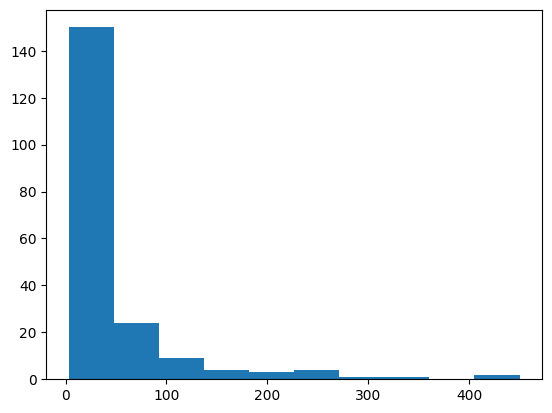

In [70]:
plt.hist(df2['Cook'])

In [71]:
arr=sorted(df2['Cook'].unique())
arr

[3.0,
 5.0,
 7.0,
 10.0,
 12.0,
 15.0,
 17.0,
 20.0,
 25.0,
 30.0,
 35.0,
 40.0,
 45.0,
 50.0,
 55.0,
 60.0,
 nan,
 65.0,
 70.0,
 75.0,
 90.0,
 100.0,
 105.0,
 120.0,
 130.0,
 135.0,
 180.0,
 195.0,
 210.0,
 240.0,
 270.0,
 300.0,
 360.0,
 420.0,
 450.0]

In [72]:
for i in range(len(arr)-1):
    print(arr[i+1]-arr[i])

2.0
2.0
3.0
2.0
3.0
2.0
3.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
nan
nan
5.0
5.0
15.0
10.0
5.0
15.0
10.0
5.0
45.0
15.0
15.0
30.0
30.0
30.0
60.0
60.0
30.0


Hence we can see that the data we have is continuous and so KNN - Imputer method can be applied to fill up the missing values.

In [73]:
from sklearn.impute import KNNImputer

df2['Cook'] = df2['Cook'].astype(float)
col_to_imp = df2['Cook'].values.reshape(-1, 1)

In [74]:
imputer = KNNImputer(n_neighbors=5)
imp_col = imputer.fit_transform(col_to_imp)
df2['Cook'] = imp_col

In [75]:
df2['Cook'] = df2['Cook'].apply(lambda x: round(x) if not pd.isna(x) else np.nan).astype('Int64')

In [76]:
df2

,Item,Difficulty,Serves,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Prep,Cook,Ratings,No_of_Ratings
0,Chicken & chorizo jambalaya,Easy,4,445,10.0,3.0,64.0,7.0,2.0,30.0,1.2,10,45,4.8,2545
1,Chicken noodle soup,Easy,2,217,2.0,0.4,26.0,1.0,0.6,26.0,2.5,10,30,4.8,751
2,Chicken pasta bake,Easy,6,575,30.0,14.0,41.0,9.0,5.0,33.0,0.5,30,45,4.7,593
3,Chicken jalfrezi,Easy,4,252,8.0,1.0,11.0,9.0,5.0,30.0,0.4,10,60,4.5,459
4,Chinese chicken curry,Easy,4,264,8.0,1.0,7.0,3.0,2.0,40.0,0.7,15,40,4.7,477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,Easy,4,491,32.0,8.0,24.0,10.0,8.0,23.0,2.5,5,15,4.5,149
206,Sausage & white bean casserole,Easy,4,363,17.0,6.0,32.0,15.0,11.0,16.0,1.2,20,65,4.5,100
207,Chipotle sweet potato & black bean stew with c...,Easy,4,547,23.0,12.0,60.0,12.0,15.0,18.0,1.5,10,50,4.8,132
208,"Salmon with sesame, soy & ginger noodles",Easy,2,749,27.0,5.0,78.0,27.0,4.0,42.0,4.0,10,20,4.6,40


Now Adding a total time column

In [77]:
df2['Total time'] = df2['Prep'] + df2['Cook']

In [78]:
df2.drop(['Prep','Cook'], axis=1, inplace=True)

In [79]:
df2

,Item,Difficulty,Serves,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Ratings,No_of_Ratings,Total time
0,Chicken & chorizo jambalaya,Easy,4,445,10.0,3.0,64.0,7.0,2.0,30.0,1.2,4.8,2545,55
1,Chicken noodle soup,Easy,2,217,2.0,0.4,26.0,1.0,0.6,26.0,2.5,4.8,751,40
2,Chicken pasta bake,Easy,6,575,30.0,14.0,41.0,9.0,5.0,33.0,0.5,4.7,593,75
3,Chicken jalfrezi,Easy,4,252,8.0,1.0,11.0,9.0,5.0,30.0,0.4,4.5,459,70
4,Chinese chicken curry,Easy,4,264,8.0,1.0,7.0,3.0,2.0,40.0,0.7,4.7,477,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,Easy,4,491,32.0,8.0,24.0,10.0,8.0,23.0,2.5,4.5,149,20
206,Sausage & white bean casserole,Easy,4,363,17.0,6.0,32.0,15.0,11.0,16.0,1.2,4.5,100,85
207,Chipotle sweet potato & black bean stew with c...,Easy,4,547,23.0,12.0,60.0,12.0,15.0,18.0,1.5,4.8,132,60
208,"Salmon with sesame, soy & ginger noodles",Easy,2,749,27.0,5.0,78.0,27.0,4.0,42.0,4.0,4.6,40,30


In [80]:
#moving total time after Cook
column_to_move = 'Total time'
desired_position = 11

In [81]:
column = df2.pop(column_to_move)

In [82]:
df2.insert(desired_position, column_to_move, column)

In [83]:
df2

,Item,Difficulty,Serves,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Total time,Ratings,No_of_Ratings
0,Chicken & chorizo jambalaya,Easy,4,445,10.0,3.0,64.0,7.0,2.0,30.0,1.2,55,4.8,2545
1,Chicken noodle soup,Easy,2,217,2.0,0.4,26.0,1.0,0.6,26.0,2.5,40,4.8,751
2,Chicken pasta bake,Easy,6,575,30.0,14.0,41.0,9.0,5.0,33.0,0.5,75,4.7,593
3,Chicken jalfrezi,Easy,4,252,8.0,1.0,11.0,9.0,5.0,30.0,0.4,70,4.5,459
4,Chinese chicken curry,Easy,4,264,8.0,1.0,7.0,3.0,2.0,40.0,0.7,55,4.7,477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,Easy,4,491,32.0,8.0,24.0,10.0,8.0,23.0,2.5,20,4.5,149
206,Sausage & white bean casserole,Easy,4,363,17.0,6.0,32.0,15.0,11.0,16.0,1.2,85,4.5,100
207,Chipotle sweet potato & black bean stew with c...,Easy,4,547,23.0,12.0,60.0,12.0,15.0,18.0,1.5,60,4.8,132
208,"Salmon with sesame, soy & ginger noodles",Easy,2,749,27.0,5.0,78.0,27.0,4.0,42.0,4.0,30,4.6,40


So our dataset is now ready to be used to perform analysis.

## EDA

In [84]:
df3=df2.copy()
df3

,Item,Difficulty,Serves,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Total time,Ratings,No_of_Ratings
0,Chicken & chorizo jambalaya,Easy,4,445,10.0,3.0,64.0,7.0,2.0,30.0,1.2,55,4.8,2545
1,Chicken noodle soup,Easy,2,217,2.0,0.4,26.0,1.0,0.6,26.0,2.5,40,4.8,751
2,Chicken pasta bake,Easy,6,575,30.0,14.0,41.0,9.0,5.0,33.0,0.5,75,4.7,593
3,Chicken jalfrezi,Easy,4,252,8.0,1.0,11.0,9.0,5.0,30.0,0.4,70,4.5,459
4,Chinese chicken curry,Easy,4,264,8.0,1.0,7.0,3.0,2.0,40.0,0.7,55,4.7,477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,Easy,4,491,32.0,8.0,24.0,10.0,8.0,23.0,2.5,20,4.5,149
206,Sausage & white bean casserole,Easy,4,363,17.0,6.0,32.0,15.0,11.0,16.0,1.2,85,4.5,100
207,Chipotle sweet potato & black bean stew with c...,Easy,4,547,23.0,12.0,60.0,12.0,15.0,18.0,1.5,60,4.8,132
208,"Salmon with sesame, soy & ginger noodles",Easy,2,749,27.0,5.0,78.0,27.0,4.0,42.0,4.0,30,4.6,40


In [85]:
df3['Item'].nunique()

210

In [86]:
diffs=df3.Difficulty.unique()
diffs

array(['Easy', 'More effort', 'A challenge'], dtype=object)

([<matplotlib.patches.Wedge at 0x2307e403730>,
 [Text(-1.2674062626214344, 0.289277315854471, 'Easy'),
  Text(1.253151663741899, -0.3458480991142079, 'More effort'),
  Text(1.2986909772741126, -0.058324484968242496, 'A challenge')],
 [Text(-0.7799423154593443, 0.1780168097565975, '92.9%'),
  Text(0.7711702546103993, -0.2128295994548971, '5.7%'),
  Text(0.7991944475533, -0.035891990749687686, '1.4%')])

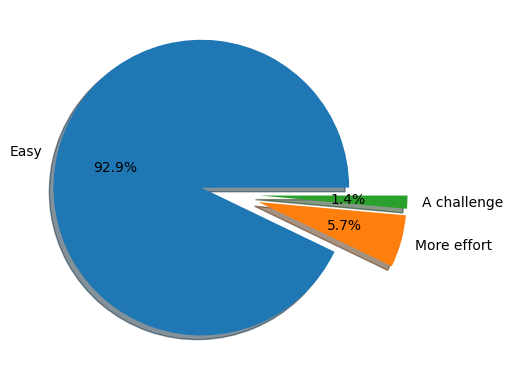

In [87]:
diff_types=df3.Difficulty.value_counts()[:3]
plt.pie(diff_types, explode=np.full(3,0.2),autopct='%1.1f%%',labels=diff_types.index[:3],shadow=True, )

So most of the recipies are easy.

#### Average each nutrient in each group of food and the nutrient stats themselves

In [88]:
df4=df3[['kcal','fat','saturates','carbs','sugars','fibre','protein','salt']]
df4

,kcal,fat,saturates,carbs,sugars,fibre,protein,salt
0,445,10.0,3.0,64.0,7.0,2.0,30.0,1.2
1,217,2.0,0.4,26.0,1.0,0.6,26.0,2.5
2,575,30.0,14.0,41.0,9.0,5.0,33.0,0.5
3,252,8.0,1.0,11.0,9.0,5.0,30.0,0.4
4,264,8.0,1.0,7.0,3.0,2.0,40.0,0.7
...,...,...,...,...,...,...,...,...
205,491,32.0,8.0,24.0,10.0,8.0,23.0,2.5
206,363,17.0,6.0,32.0,15.0,11.0,16.0,1.2
207,547,23.0,12.0,60.0,12.0,15.0,18.0,1.5
208,749,27.0,5.0,78.0,27.0,4.0,42.0,4.0


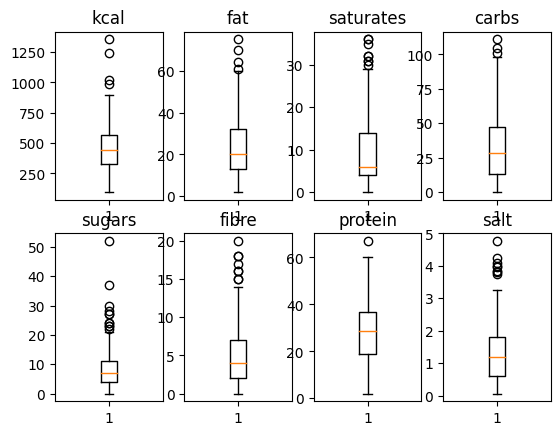

In [89]:
fig, axes = plt.subplots(2, 4)


for i in range(0, 8):
    axes[i // 4, i % 4].boxplot(df4.iloc[:, i])
    axes[i // 4, i % 4].set_title(df4.columns[i])

# Set the titles of the subplots
axes[0, 0].set_title('kcal')
axes[0, 1].set_title('fat')
axes[0, 2].set_title('saturates')
axes[0, 3].set_title('carbs')
axes[1, 0].set_title('sugars')
axes[1, 1].set_title('fibre')
axes[1, 2].set_title('protein')
axes[1, 3].set_title('salt')

# Show the plot
plt.show()

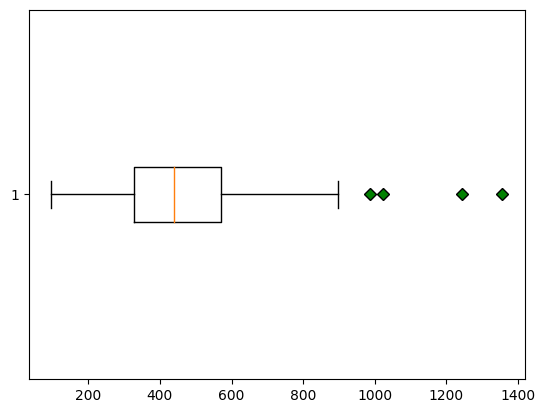

In [90]:
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(df3.kcal, vert=False, flierprops=green_diamond);

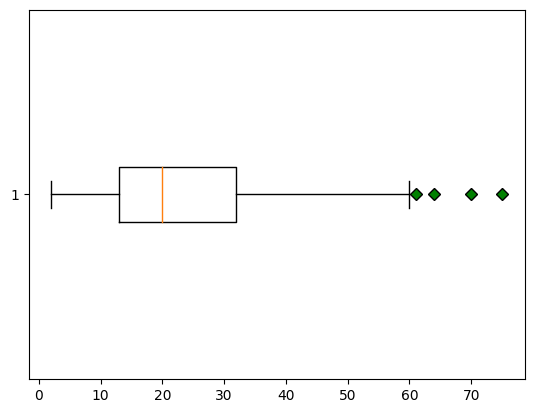

In [91]:
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(df3.fat, vert=False, flierprops=green_diamond);

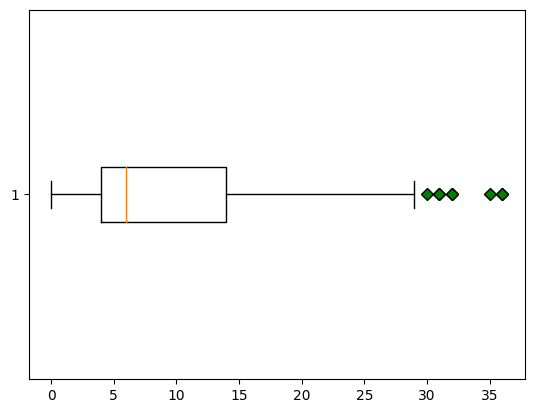

In [92]:
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(df3.saturates, vert=False, flierprops=green_diamond);

#### Relationship between Ratings and the number of people rated

In [93]:
avg_rating_zscore = (df3['Ratings'] - df3['Ratings'].mean()) / df3['Ratings'].std()

In [94]:
num_of_ratings_zscores = (df3['No_of_Ratings'] - df3['No_of_Ratings'].mean()) / df2['No_of_Ratings'].std()

In [95]:
zscore_threshold = 3

In [96]:
negative_outliers = df3[(avg_rating_zscore < -zscore_threshold) | (num_of_ratings_zscores < -zscore_threshold)]

In [97]:
positive_outliers = df3[(avg_rating_zscore > zscore_threshold) | (num_of_ratings_zscores > zscore_threshold)]

In [98]:
print("Items with positive outliers : ")
print(positive_outliers['Item'])

Items with positive outliers : 
0    Chicken & chorizo jambalaya
Name: Item, dtype: object


In [99]:
print("Items with negative outliers : ")
print(negative_outliers['Item'])

Items with negative outliers : 
145    Paneer in herby tomato sauce
146    Herb & spice paneer fritters
147     Spiced broccoli with paneer
149        Spinach dhal with paneer
Name: Item, dtype: object


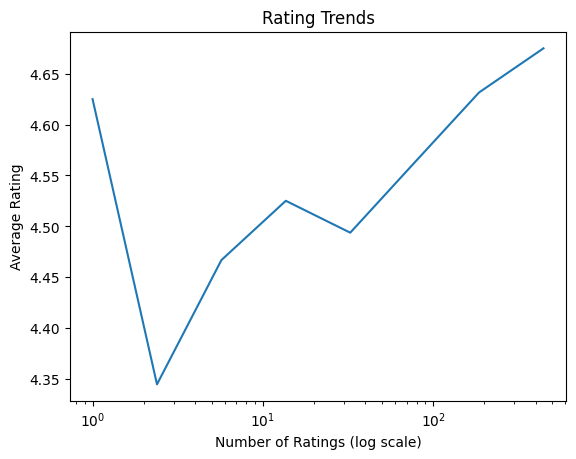

In [100]:
bin_edges = np.logspace(np.log10(df2['No_of_Ratings'].min()), np.log10(df2['No_of_Ratings'].max()), num=10)

average_rating_by_bin = df2.groupby(pd.cut(df2['No_of_Ratings'], bins=bin_edges))['Ratings'].mean()

plt.plot(bin_edges[:-1], average_rating_by_bin.values)
plt.xscale('log')
plt.xlabel('Number of Ratings (log scale)')
plt.ylabel('Average Rating')
plt.title('Rating Trends')
plt.show()

In [104]:
categorywise_rating_avg = []

In [105]:
i=0
for freq in item_freq:
    rating_sum = 0;
    for i in range(i, i + freq):
        rating_sum = rating_sum + df3.iloc[i]['Ratings']
    categorywise_rating_avg.append(np.round(rating_sum / freq, 2))

categorywise_rating_avg

[4.66, 4.58, 4.61, 4.5, 4.52, 4.35, 4.58]

In [106]:
categorywise_num_rating_avg = []

In [107]:
i=0
for freq in item_freq:
    rating_sum = 0;
    for i in range(i, i + freq):
        rating_sum = rating_sum + df2.iloc[i]['No_of_Ratings']
    categorywise_num_rating_avg.append(np.round(rating_sum / freq, 2))

categorywise_num_rating_avg

[431.07, 184.0, 92.3, 52.97, 26.27, 154.8, 100.67]

In [108]:
df5 = df2.copy()

In [111]:
df5['No_Rating_Quartile_Range'] = pd.qcut(df5['No_of_Ratings'], q=4, labels=False)

In [113]:
grouped = df5.groupby('No_Rating_Quartile_Range')['Item'].apply(list)

In [114]:
df5

,Item,Difficulty,Serves,kcal,fat,saturates,carbs,sugars,fibre,protein,salt,Total time,Ratings,No_of_Ratings,No_Rating_Quartile_Range
0,Chicken & chorizo jambalaya,Easy,4,445,10.0,3.0,64.0,7.0,2.0,30.0,1.2,55,4.8,2545,3
1,Chicken noodle soup,Easy,2,217,2.0,0.4,26.0,1.0,0.6,26.0,2.5,40,4.8,751,3
2,Chicken pasta bake,Easy,6,575,30.0,14.0,41.0,9.0,5.0,33.0,0.5,75,4.7,593,3
3,Chicken jalfrezi,Easy,4,252,8.0,1.0,11.0,9.0,5.0,30.0,0.4,70,4.5,459,3
4,Chinese chicken curry,Easy,4,264,8.0,1.0,7.0,3.0,2.0,40.0,0.7,55,4.7,477,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Butter bean & chorizo stew,Easy,4,491,32.0,8.0,24.0,10.0,8.0,23.0,2.5,20,4.5,149,2
206,Sausage & white bean casserole,Easy,4,363,17.0,6.0,32.0,15.0,11.0,16.0,1.2,85,4.5,100,2
207,Chipotle sweet potato & black bean stew with c...,Easy,4,547,23.0,12.0,60.0,12.0,15.0,18.0,1.5,60,4.8,132,2
208,"Salmon with sesame, soy & ginger noodles",Easy,2,749,27.0,5.0,78.0,27.0,4.0,42.0,4.0,30,4.6,40,1
